# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# 10.1.3 パーセプトロン

In [4]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron
from matplotlib.colors import ListedColormap

In [5]:
iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [6]:
y_pred

array([1])

Saving figure perceptron_iris_plot


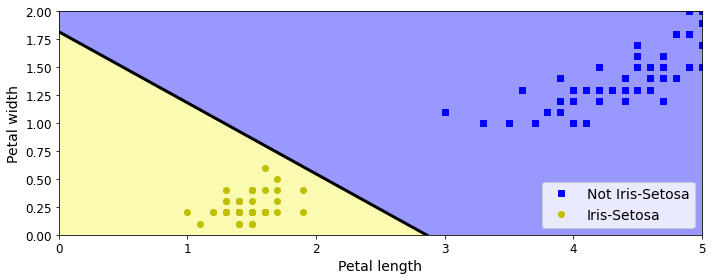

In [13]:
axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

# 境界
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

# 予測毎に色分け
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# 10.1.4 MLPとバックプロパゲーション

In [30]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

Saving figure activation_functions_plot


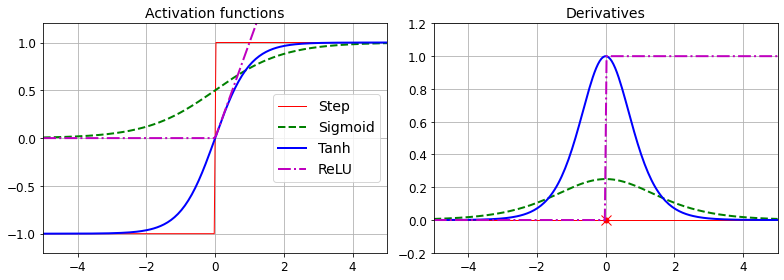

In [29]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
# plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

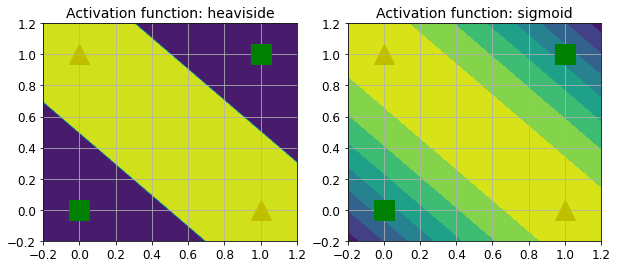

In [31]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# 10.2.2 シーケンシャルAPIを使った画像分類器の構築

In [7]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [8]:
tf.__version__, keras.__version__

('2.6.0', '2.6.0')

In [9]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [10]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [11]:
# 検証データと学習データの切り分けとスケーリング（0-1）をする
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

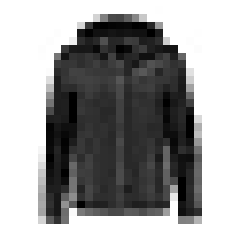

In [12]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [13]:
# ラベルは0-9のクラスID
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [14]:
# IDとの対応
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Saving figure fashion_mnist_plot


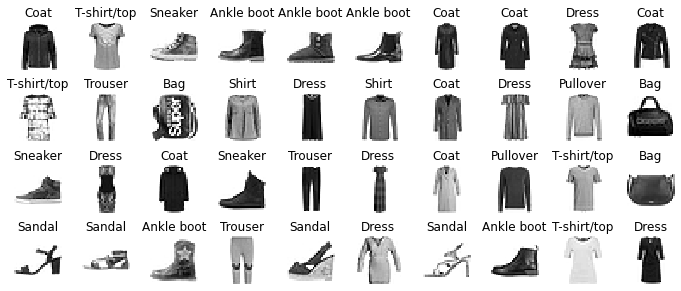

In [15]:
# 画像サンプルの確認
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [16]:
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[28, 28]))
# model.add(keras.layers.Dense(300, activation="relu"))
# model.add(keras.layers.Dense(100, activation="relu"))
# model.add(keras.layers.Dense(10, activation="softmax"))

2021-10-24 06:53:09.712774: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [18]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [19]:
model.layers

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


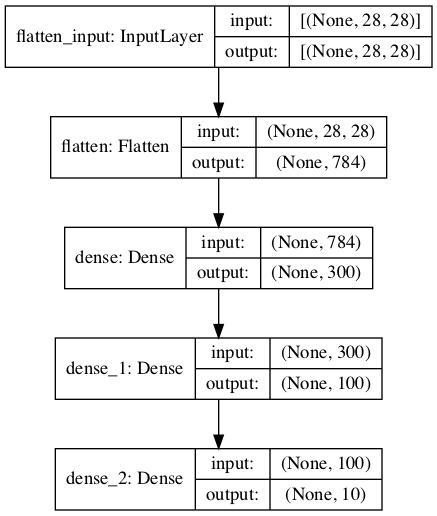

In [21]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [94]:
# 以下のように書いても同様
# model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=keras.optimizers.SGD(),
#               metrics=[keras.metrics.sparse_categorical_accuracy])

In [23]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), verbose=0)

2021-10-24 06:54:31.846960: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [24]:
history.params

{'verbose': 0, 'epochs': 30, 'steps': 1719}

Saving figure keras_learning_curves_plot


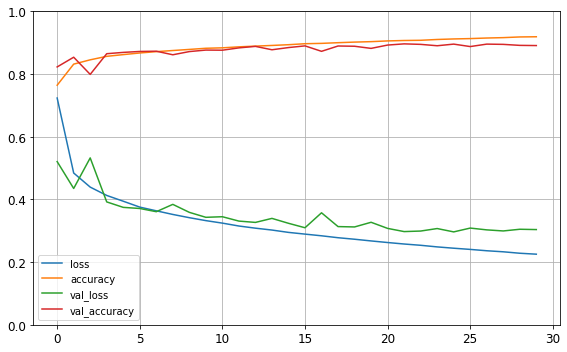

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [26]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 980us/step - loss: 0.3366 - accuracy: 0.8831


[0.33662697672843933, 0.8830999732017517]

In [27]:
X_new = X_test[:3]
y_new = y_test[:3]

# y_pred = model.predict_classes(X_new) # 非推奨
y_pred = np.argmax(model.predict(X_new), axis=-1) # array([9, 2, 1])
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Saving figure fashion_mnist_images_plot


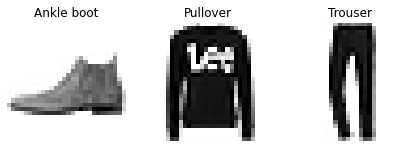

In [28]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# 10.2.3 シーケンシャルAPIを使った回帰MLPの構築

In [29]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
# California housing datasetの読み込みと前処理
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [32]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), verbose=0)
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

162/162 [==============================] - 0s 481us/step - loss: 0.4212


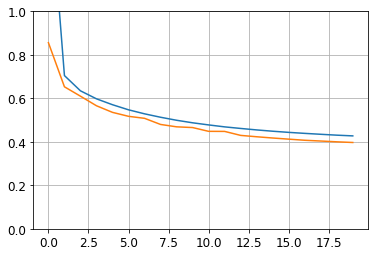

In [33]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [34]:
y_pred

array([[0.38856643],
       [1.6792021 ],
       [3.1022794 ]], dtype=float32)

# 10.2.4 関数型APIを使った複雑なモデルの構築

sequentialでないモデル（Wide & Deep neural networkのような）を作るにはどうしたら良いか？

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [38]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid), verbose=0)
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

162/162 [==============================] - 0s 555us/step - loss: 0.4032


異なる2種類の特徴量を持つサブセットをインプットとして与える場合はどうするか？

- wide path: features 0 to 4
- deep path: features 2 to 7

※重複はあっても良い

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

In [41]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [42]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid), verbose=0)
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))

162/162 [==============================] - 0s 650us/step - loss: 0.4219


正則化などのために補助出力を出したい場合

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

In [45]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

In [46]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [47]:
history = model.fit([X_train_A, X_train_B], [y_train, y_train], epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]), verbose=0)

In [48]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

162/162 [==============================] - 0s 1ms/step - loss: 0.4668 - main_output_loss: 0.4178 - aux_output_loss: 0.9082


# 10.2.5 サブクラス化APIを使ったダイナミックなモデルの構築

In [51]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [52]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)), verbose=0)
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

162/162 [==============================] - 0s 591us/step - loss: 0.5279 - output_1_loss: 0.4605 - output_2_loss: 1.1352


In [54]:
# モデルは柔軟に組めるが、層の接続情報などは得られない
model.summary()

Model: "wide_and_deep_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             multiple                  210       
_________________________________________________________________
dense_13 (Dense)             multiple                  930       
_________________________________________________________________
dense_14 (Dense)             multiple                  36        
_________________________________________________________________
dense_15 (Dense)             multiple                  31        
Total params: 1,207
Trainable params: 1,207
Non-trainable params: 0
_________________________________________________________________


# 10.2.6 モデルの保存と復元

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])  

In [57]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0)
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 627us/step - loss: 0.4382


In [58]:
model.save("my_keras_model.h5")

In [59]:
model = keras.models.load_model("my_keras_model.h5")

In [63]:
model.predict(X_new)

array([[0.5400236],
       [1.6505971],
       [3.0098243]], dtype=float32)

- サブクラス化モデルを使った場合は、上記の方法では保存できない。
- save_weights/load_weightsを使いパラメータは保存できるが、他の情報は保存復元の処理を別途実装しないといけない。

In [61]:
model.save_weights("my_keras_weights.ckpt")

In [62]:
model.load_weights("my_keras_weights.ckpt")

# 10.2.7 コールバックの使い方

In [65]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [70]:
# 定期的にモデルのチェックポイントを保存
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb],
                    verbose=0)
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 587us/step - loss: 0.3767


In [71]:
# Early Stopping
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb],
                    verbose=0)
mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 568us/step - loss: 0.3302


In [74]:
# カスタムコールバック関数
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [75]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb],
                    verbose=0)


val/train: 0.96


# 10.2.8 TensorBoardを使った可視化

In [76]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [97]:
# ログの保存先の作成
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [81]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [87]:
run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2021_10_24-19_18_48'

In [88]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [89]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb], 
                    verbose=0)

2021-10-24 19:18:51.861045: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-24 19:18:51.861070: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-24 19:18:51.861431: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-24 19:18:52.179868: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-24 19:18:52.179884: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-24 19:18:52.199306: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-24 19:18:52.200330: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-24 19:18:52.201863: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_logs/run_2021_10_24-19_18_48/train/plugins/profile/2021_10_24_19_18_52

2021-10-24 19:18:52.20246

In [98]:
# %load_ext tensorboard
# %tensorboard --logdir=./my_logs --port=6006

In [85]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [91]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2021_10_24-19_19_20'

In [92]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=0.05))

In [94]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb], 
                    verbose=0)

2021-10-24 19:19:53.915135: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-24 19:19:53.915160: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-24 19:19:53.915802: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-24 19:19:53.976681: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-24 19:19:53.976700: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-24 19:19:53.984500: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-24 19:19:53.985195: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-24 19:19:53.985851: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_logs/run_2021_10_24-19_19_20/train/plugins/profile/2021_10_24_19_19_53

2021-10-24 19:19:53.98652

In [96]:
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 37507), started 0:04:00 ago. (Use '!kill 37507' to kill it.)

In [99]:
# その他のロギングオプション
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, write_steps_per_second=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# 10.3 ニューラルネットワークのハイパーパラメータの微調整

In [100]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [102]:
# シーケンシャルな多層モデルを作成する関数
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [103]:
# scikit_learn回帰ライクに使用できる
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [104]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)], 
              verbose=0)

In [105]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 641us/step - loss: 0.3412


In [106]:
y_pred = keras_reg.predict(X_new)

In [107]:
np.random.seed(42)
tf.random.set_seed(42)

In [109]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100)               .tolist(),
    "learning_rate": reciprocal(3e-4, 3e-2)      .rvs(1000).tolist(),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)], 
                  verbose=0)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
121/121 [==============================] - 0s 582us/step - loss: 0.3774
[CV] END learning_rate=0.008171782257177468, n_hidden=1, n_neurons=28; total time=   3.7s
121/121 [==============================] - 0s 588us/step - loss: 0.3993
[CV] END learning_rate=0.008171782257177468, n_hidden=1, n_neurons=28; total time=   2.7s
121/121 [==============================] - 0s 592us/step - loss: 0.3578
[CV] END learning_rate=0.008171782257177468, n_hidden=1, n_neurons=28; total time=   5.0s
121/121 [==============================] - 0s 502us/step - loss: 0.3015
[CV] END learning_rate=0.02003770349708889, n_hidden=3, n_neurons=29; total time=  12.8s
121/121 [==============================] - 0s 656us/step - loss: 0.3119
[CV] END learning_rate=0.02003770349708889, n_hidden=3, n_neurons=29; total time=   6.2s
121/121 [==============================] - 0s 500us/step - loss: 0.2943
[CV] END learning_rate=0.02003770349708889, n_hidden=3, n_n

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fedc065bbd0>,
                   param_distributions={'learning_rate': [0.006232868841909281,
                                                          0.0072723434950311555,
                                                          0.014980025679402079,
                                                          0.000947233987395861,
                                                          0.0028574009317206828,
                                                          0.0008308835070579019,
                                                          0.028343747518194726,
                                                          0.02318675291623005,
                                                          0.0003597285254120405,
                                                          0.00773163956398385...
                                                          0.02320888266

In [110]:
rnd_search_cv.best_params_, rnd_search_cv.best_score_

({'n_neurons': 68, 'n_hidden': 3, 'learning_rate': 0.021020141525691302},
 -0.2881048421065013)

In [111]:
rnd_search_cv.score(X_test, y_test)

162/162 [==============================] - 0s 535us/step - loss: 0.2787


-0.2786976993083954

In [112]:
model = rnd_search_cv.best_estimator_.model

In [113]:
model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 636us/step - loss: 0.2787


0.2786976993083954

# 10.4 演習問題

 ## 10. 

MINSTデータセットで深層MLPを訓練し、98%を超える適合率が得られるかどうかを調べてみよう。この章で説明した方法を使って最適な学習率を探そう（つまり、学習率を指数的に上げ、損失をグラフにし、損失が反転上昇する点を明らかにする）。

In [31]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from sklearn.model_selection import train_test_split

In [22]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

print(X_train_full.shape, X_train_full.dtype)

# 学習データと検証データの分割と強度の正規化
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

(60000, 28, 28) uint8


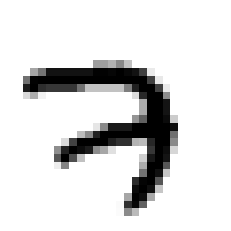

In [23]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [26]:
X_train.shape, X_valid.shape, X_test.shape

((55000, 28, 28), (5000, 28, 28), (10000, 28, 28))

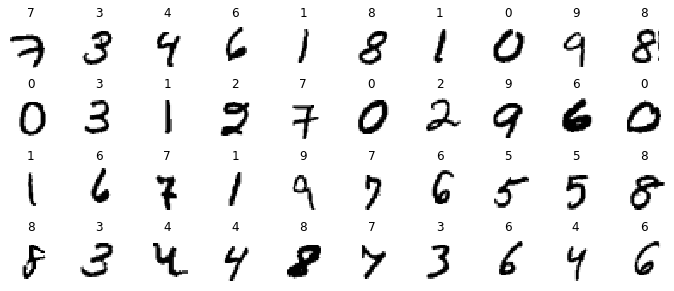

In [28]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [29]:
# 反復ごとに学習率を上げるためのコールバックが必要。また、各反復での学習率と損失を記録する。
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

In [30]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [32]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [34]:
# 1 epochだけ試してみる
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.6020 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

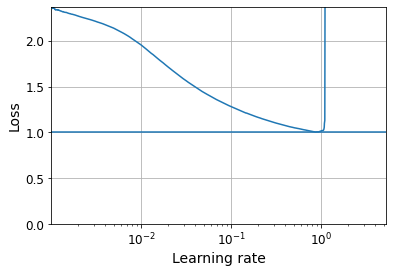

In [49]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [39]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'./my_mnist_logs/run_001'

In [41]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

2021-11-23 11:15:21.424273: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-23 11:15:21.424292: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-23 11:15:21.428905: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/100
 120/1719 [=>............................] - ETA: 2s - loss: 0.8206 - accuracy: 0.7393

2021-11-23 11:15:21.879156: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-23 11:15:21.879172: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-23 11:15:21.883718: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-23 11:15:21.895267: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-23 11:15:21.905164: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_mnist_logs/run_001/train/plugins/profile/2021_11_23_11_15_21

2021-11-23 11:15:21.907068: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./my_mnist_logs/run_001/train/plugins/profile/2021_11_23_11_15_21/mochidzukiyoshihikonoMacBook-Pro.local.trace.json.gz
2021-11-23 11:15:21.917120: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./my_mnist_lo

1719/1719 [==============================] - 3s 2ms/step - loss: 0.2356 - accuracy: 0.9263 - val_loss: 0.1035 - val_accuracy: 0.9704
Epoch 2/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0936 - accuracy: 0.9708 - val_loss: 0.0996 - val_accuracy: 0.9704
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0673 - accuracy: 0.9783 - val_loss: 0.0776 - val_accuracy: 0.9764
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0484 - accuracy: 0.9844 - val_loss: 0.0872 - val_accuracy: 0.9760
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0351 - accuracy: 0.9886 - val_loss: 0.0769 - val_accuracy: 0.9798
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0304 - accuracy: 0.9900 - val_loss: 0.0802 - val_accuracy: 0.9806
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0250 - accuracy: 0.9916 - val_loss: 0.0819 - val_accuracy: 0.97

In [42]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 920us/step - loss: 0.0800 - accuracy: 0.9819


[0.07995845377445221, 0.9818999767303467]

In [44]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs --port=6006